<h1 style="text-align:center">Variable Length Pendulum</h1>
<p style="text-align:center">Dr. Joshua Vaughan <br>
<a href="mailto:joshua.vaughan@louisiana.edu">joshua.vaughan@louisiana.edu</a><br>
<a href="http://www.ucs.louisiana.edu/~jev9637/">http://www.ucs.louisiana.edu/~jev9637/</a></p>

In this notebook, we'll be looking at the simple forced pendulum shown in Figure 1. It has a point mass, $m$, suspended on an inflexible massless rod/cable of length $l$ from a perfect pin joint.  However, we are able to change the length of the rod/cable.
<p style="text-align:center">
	<img src="http://shared.crawlab.org/Pendulum_simple.png" alt="Variable Length Pendulum" width=15%><br>
    <strong>Figure 1: Variable Length Pendulum</strong>
</p>

The equation of motion for this system is:

$ \quad m l^2 \ddot{\theta} + 2 m l \dot{l} \dot{\theta} + m g l \sin{\theta} = 0 $

This can be rewritten as:

$ \quad \ddot{\theta} = - \frac{\dot{l}}{l}\dot{\theta} - \frac{g}{l} \sin{\theta} $

Generally, there would also be an equation of motion for  $l$. However, in this formulation, we are saying that we can exactly control that varible, regardless of the forces acting on it. It becomes our control input to the system.

To simulate the system, we need to write this 2nd-order differential equation as a system of first order differential equations.

To do so, define the state vector $\bar{w} = \left[\theta \ \dot{\theta}\right]^T$.

Then, the system of first-order ODEs we have to solve is:

$ \quad \dot{\bar{w}} = g(\bar{w}, \bar{u}, t) $

Writing these out, we have:

$ \quad \dot{\bar{w}}  = \left[\dot{\theta} \right.$

$\phantom{\quad \dot{\bar{w}}  = \left[\right.}\left. - \frac{\dot{l}}{l}\dot{\theta} - \frac{g}{l} \sin{\theta} \right] $

This would work, in that we could exactly specify $l$ and $\dot{l}$ for all time and simlulate this system. However, it'd be easy for us to just define a single function and let the ODE solver take care of propicating that through whatever integrals or differntiation is necessary. To do that, let's define an alternate state vector of  $\bar{w} = \left[\theta \ \dot{\theta} \ l \ \dot{l} \right]^T$. We can then right our system of first order differntial equations as:

$ \quad \dot{\bar{w}}  = \left[\dot{\theta} \right.$

$\phantom{\quad \dot{\bar{w}}  = \left[\right.} - \frac{\dot{l}}{l}\dot{\theta} - \frac{g}{l} \sin{\theta} $

$\phantom{\quad \dot{\bar{w}}  = \left[\right.} \dot{l} $

$\phantom{\quad \dot{\bar{w}}  = \left[\right.}\left. \ddot{l_d} \right]$

where $\ddot{l_d}$ will be the input function defining the desired acceleration of cable/rod length. Now, we can use that system of 1st-order differential equations to simulate the system, defining a function for $\ddot{l_d}$ that gets called from the equations of motion.

To begin we will import the NumPy library, the matplotlib plotting library, and the ```odeint``` ODE solver from the SciPy library.

In [1]:
import numpy as np              # Grab all of the NumPy functions with nickname np

In [2]:
%matplotlib inline

# Import the plotting functions 
import matplotlib.pyplot as plt

In [3]:
# Import the ODE solver
from scipy.integrate import odeint

We need to define two functions for the differential equation solver to use. The first is just the system of differential equations to solve. I've defined it below by ```eq_of_motion()```. It is just the system of equations we wrote above. The second is the input force as a function of time. I have called it ```torque()``` below. Here, it is just a pulse input in torque, lasting 0.5 seconds.

In [4]:
def eq_of_motion(w, t, p):
    """
    Defines the differential equations for the forced pendulum system

    Arguments:
        w :  vector of the state variables:
        t :  time
        p :  vector of the parameters:
    """
    theta, theta_dot, l, l_dot = w
    g, StartTime, delta_l, A_max, V_max = p = p

    # Create sysODE = (theta', theta_dot')
    sysODE = [theta_dot,
              -l_dot/l * theta_dot - g/l * np.sin(theta),
             l_dot,
             l_accel(w, t, p)]
    return sysODE


def l_accel(w, t, p):
    """
    defines the cable length acceleration as an input to the system
    
      Arguments:
        w :  vector of the state variables - as of 07/06/17, we aren't using these
        t :  time
        p :  vector of the parameters
    """
    theta, theta_dot, l, l_dot = w
    g, StartTime, delta_l, Amax, Vmax = p

    
    # Arbibrary Input - We'll change this to control the payload sway, theta
    # Currently (07/06/17), this is just a bang-coast-bang in cable length accel
    #
    # Note: You could/should call this from the input shaping library, rather 
    # than copying all the code here. I've done so to make this notebook more 
    # portable, as it doens't need the input shaping library, as is.
    # 
    # These are the times for a bang-coast-bang input 
#     t1 = StartTime
#     t2 = (Vmax/Amax) + t1
#     t3 = (delta_l/Vmax) + t1
#     t4 = (t2 + t3) - t1
#     end_time = t4

#     if t3 <= t2: # command should be bang-bang, not bang-coast-bang
#         t2 = np.sqrt(delta_l/Amax)+t1
#         t3 = 2.0 * np.sqrt(delta_l/Amax)+t1
#         end_time = t3
    
#         l_accel = Amax*(t > t1) - 2*Amax*(t > t2) + Amax*(t > t3)

#     else: # command is bang-coast-bang
#         l_accel = Amax*(t > t1) - Amax*(t > t2) - Amax*(t > t3) + Amax*(t > t4)
        
    # alternately, we could just use a sine to test the simulation    
    l_accel = A_max * (2*np.pi)**2 * np.cos(2*np.pi * t)
        
    return l_accel

In [5]:
# Define the system parameters
m = 1.0             # mass (kg)
g = 9.81            # acceleration of gravity (m/s^2)

In [6]:
# Set up simulation parameters

# ODE solver parameters
abserr = 1.0e-9
relerr = 1.0e-9
max_step = 0.01
stoptime = 10.0
numpoints = 10001

# Create the time samples for the output of the ODE solver
t = np.linspace(0.0, stoptime, numpoints)

# Initial conditions
theta_init = 10.0 * np.pi/180   # initial angle (rad)
theta_dot_init = 0.0            # initial angular velocity (rad/)
l_init = 1.0                    # initial length of the pendulum (m)
l_dot_init = 0.00               # initial pendulum change velocity (m/s)

# Set up the parameters for the input function
StartTime = 0.5          # Time the input will begin
A_max = 0.25              # Amplitude of accel of cable length (m/s^2)
V_max = 0.35              # Max velocity of cable length change (m/s)
delta_l = 1.0            # How much to change cable length (m) 

# Pack the parameters and initial conditions into arrays 
p = [g, StartTime, delta_l, A_max, V_max]
x0 = [theta_init, theta_dot_init, l_init, l_dot_init]

Now, we will actually call the ode solver, using the ```odeint()``` function from the SciPy library. For more information on ```odeint```, see [the SciPy documentation](http://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html).

In [7]:
# Call the ODE solver.
resp = odeint(eq_of_motion, x0, t, args=(p,), atol=abserr, rtol=relerr,  hmax=max_step)

The solver returns the time history of each state. To plot an individual response, we just simply pick the corresponding column. Below, we'll plot the position of the mass as a function of time.

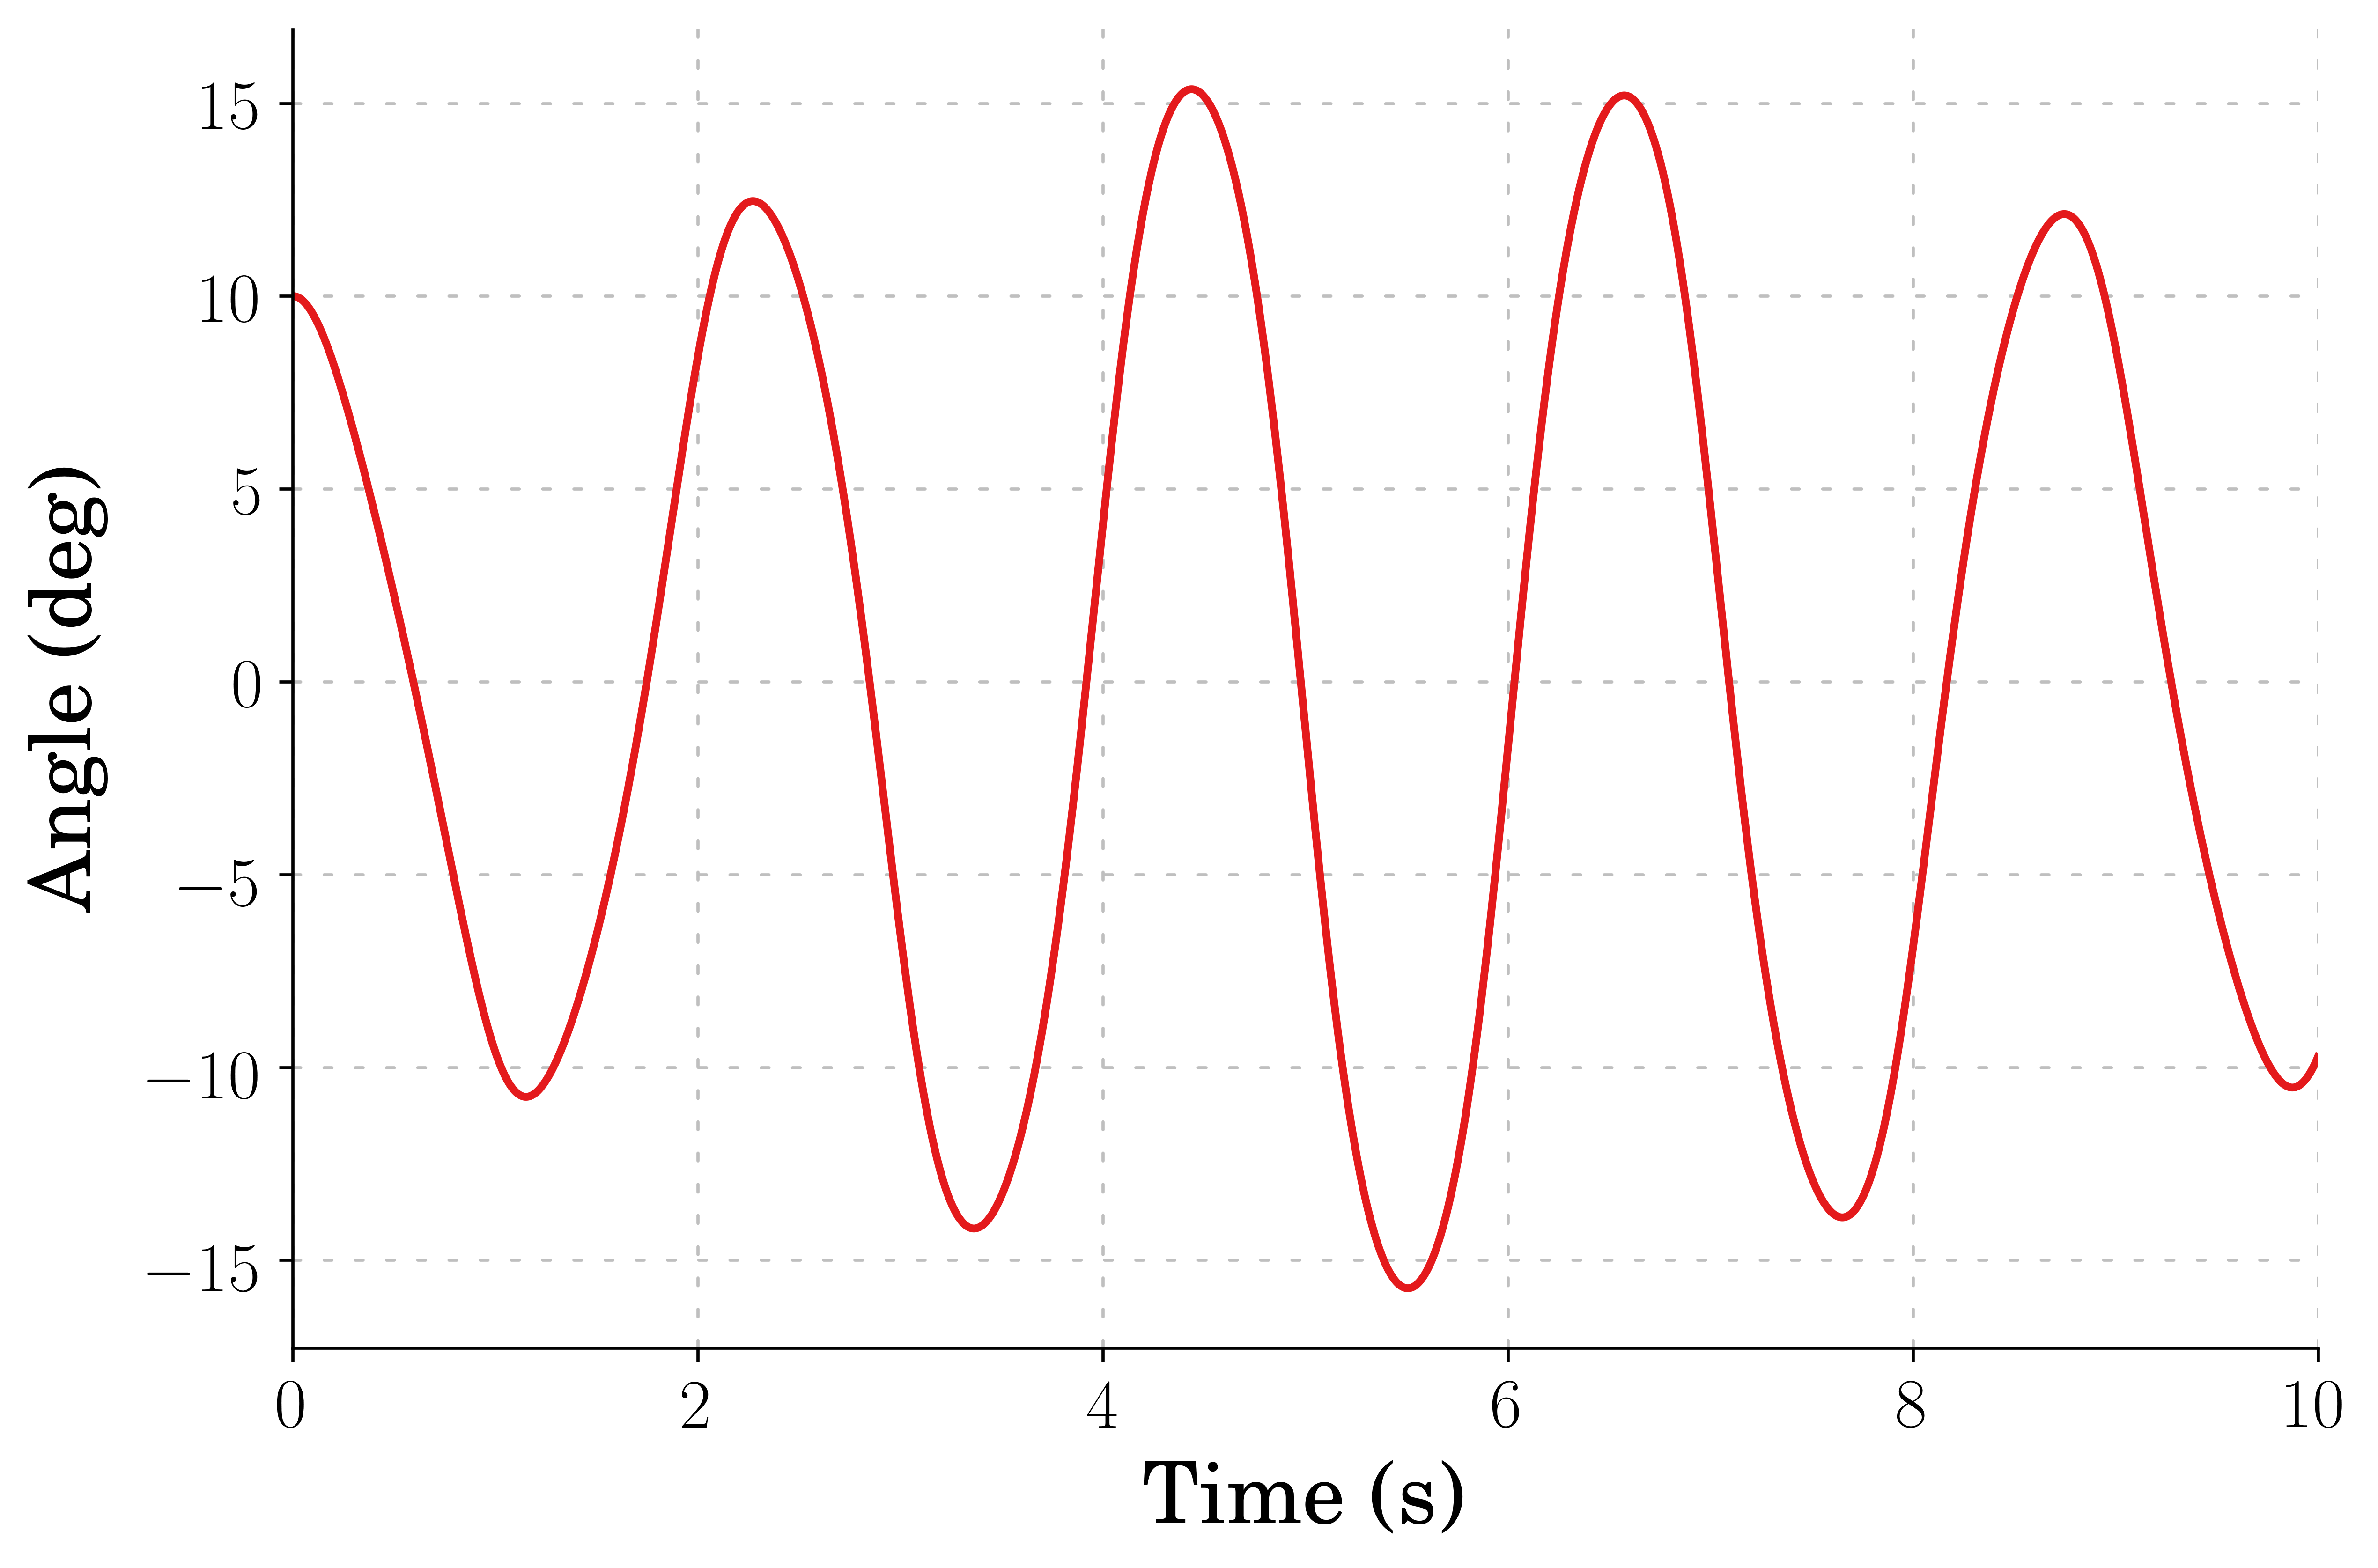

In [8]:
# Make the figure pretty, then plot the results
#   "pretty" parameters selected based on pdf output, not screen output
#   Many of these setting could also be made default by the .matplotlibrc file

# Set the plot size - 3x2 aspect ratio is best
fig = plt.figure(figsize=(6, 4))
ax = plt.gca()
plt.subplots_adjust(bottom=0.17, left=0.17, top=0.96, right=0.96)

# Change the axis units to serif
plt.setp(ax.get_ymajorticklabels(),family='serif',fontsize=18)
plt.setp(ax.get_xmajorticklabels(),family='serif',fontsize=18)

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Turn on the plot grid and set appropriate linestyle and color
ax.grid(True,linestyle=':',color='0.75')
ax.set_axisbelow(True)

# Define the X and Y axis labels
plt.xlabel('Time (s)', family='serif', fontsize=22, weight='bold', labelpad=5)
plt.ylabel('Angle (deg)', family='serif', fontsize=22, weight='bold', labelpad=10)

# Plot the first element of resp for all time. It corresponds to the position.
plt.plot(t, resp[:,0] * 180/np.pi, linewidth=2, linestyle = '-', label=r'Response')

# uncomment below and set limits if needed
plt.xlim(0, stoptime)
# plt.ylim(0,10)

# # Create the legend, then fix the fontsize
# leg = plt.legend(loc='upper right', fancybox=True)
# ltext  = leg.get_texts()
# plt.setp(ltext,family='serif',fontsize=18)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad = 0.5)

# save the figure as a high-res pdf in the current folder
# It's saved at the original 6x4 size
# plt.savefig('MCHE485_DirectTorquePendulum_nonlinear.pdf')

fig.set_size_inches(9, 6) # Resize the figure for better display in the notebook

Now, let's plot the cable length.

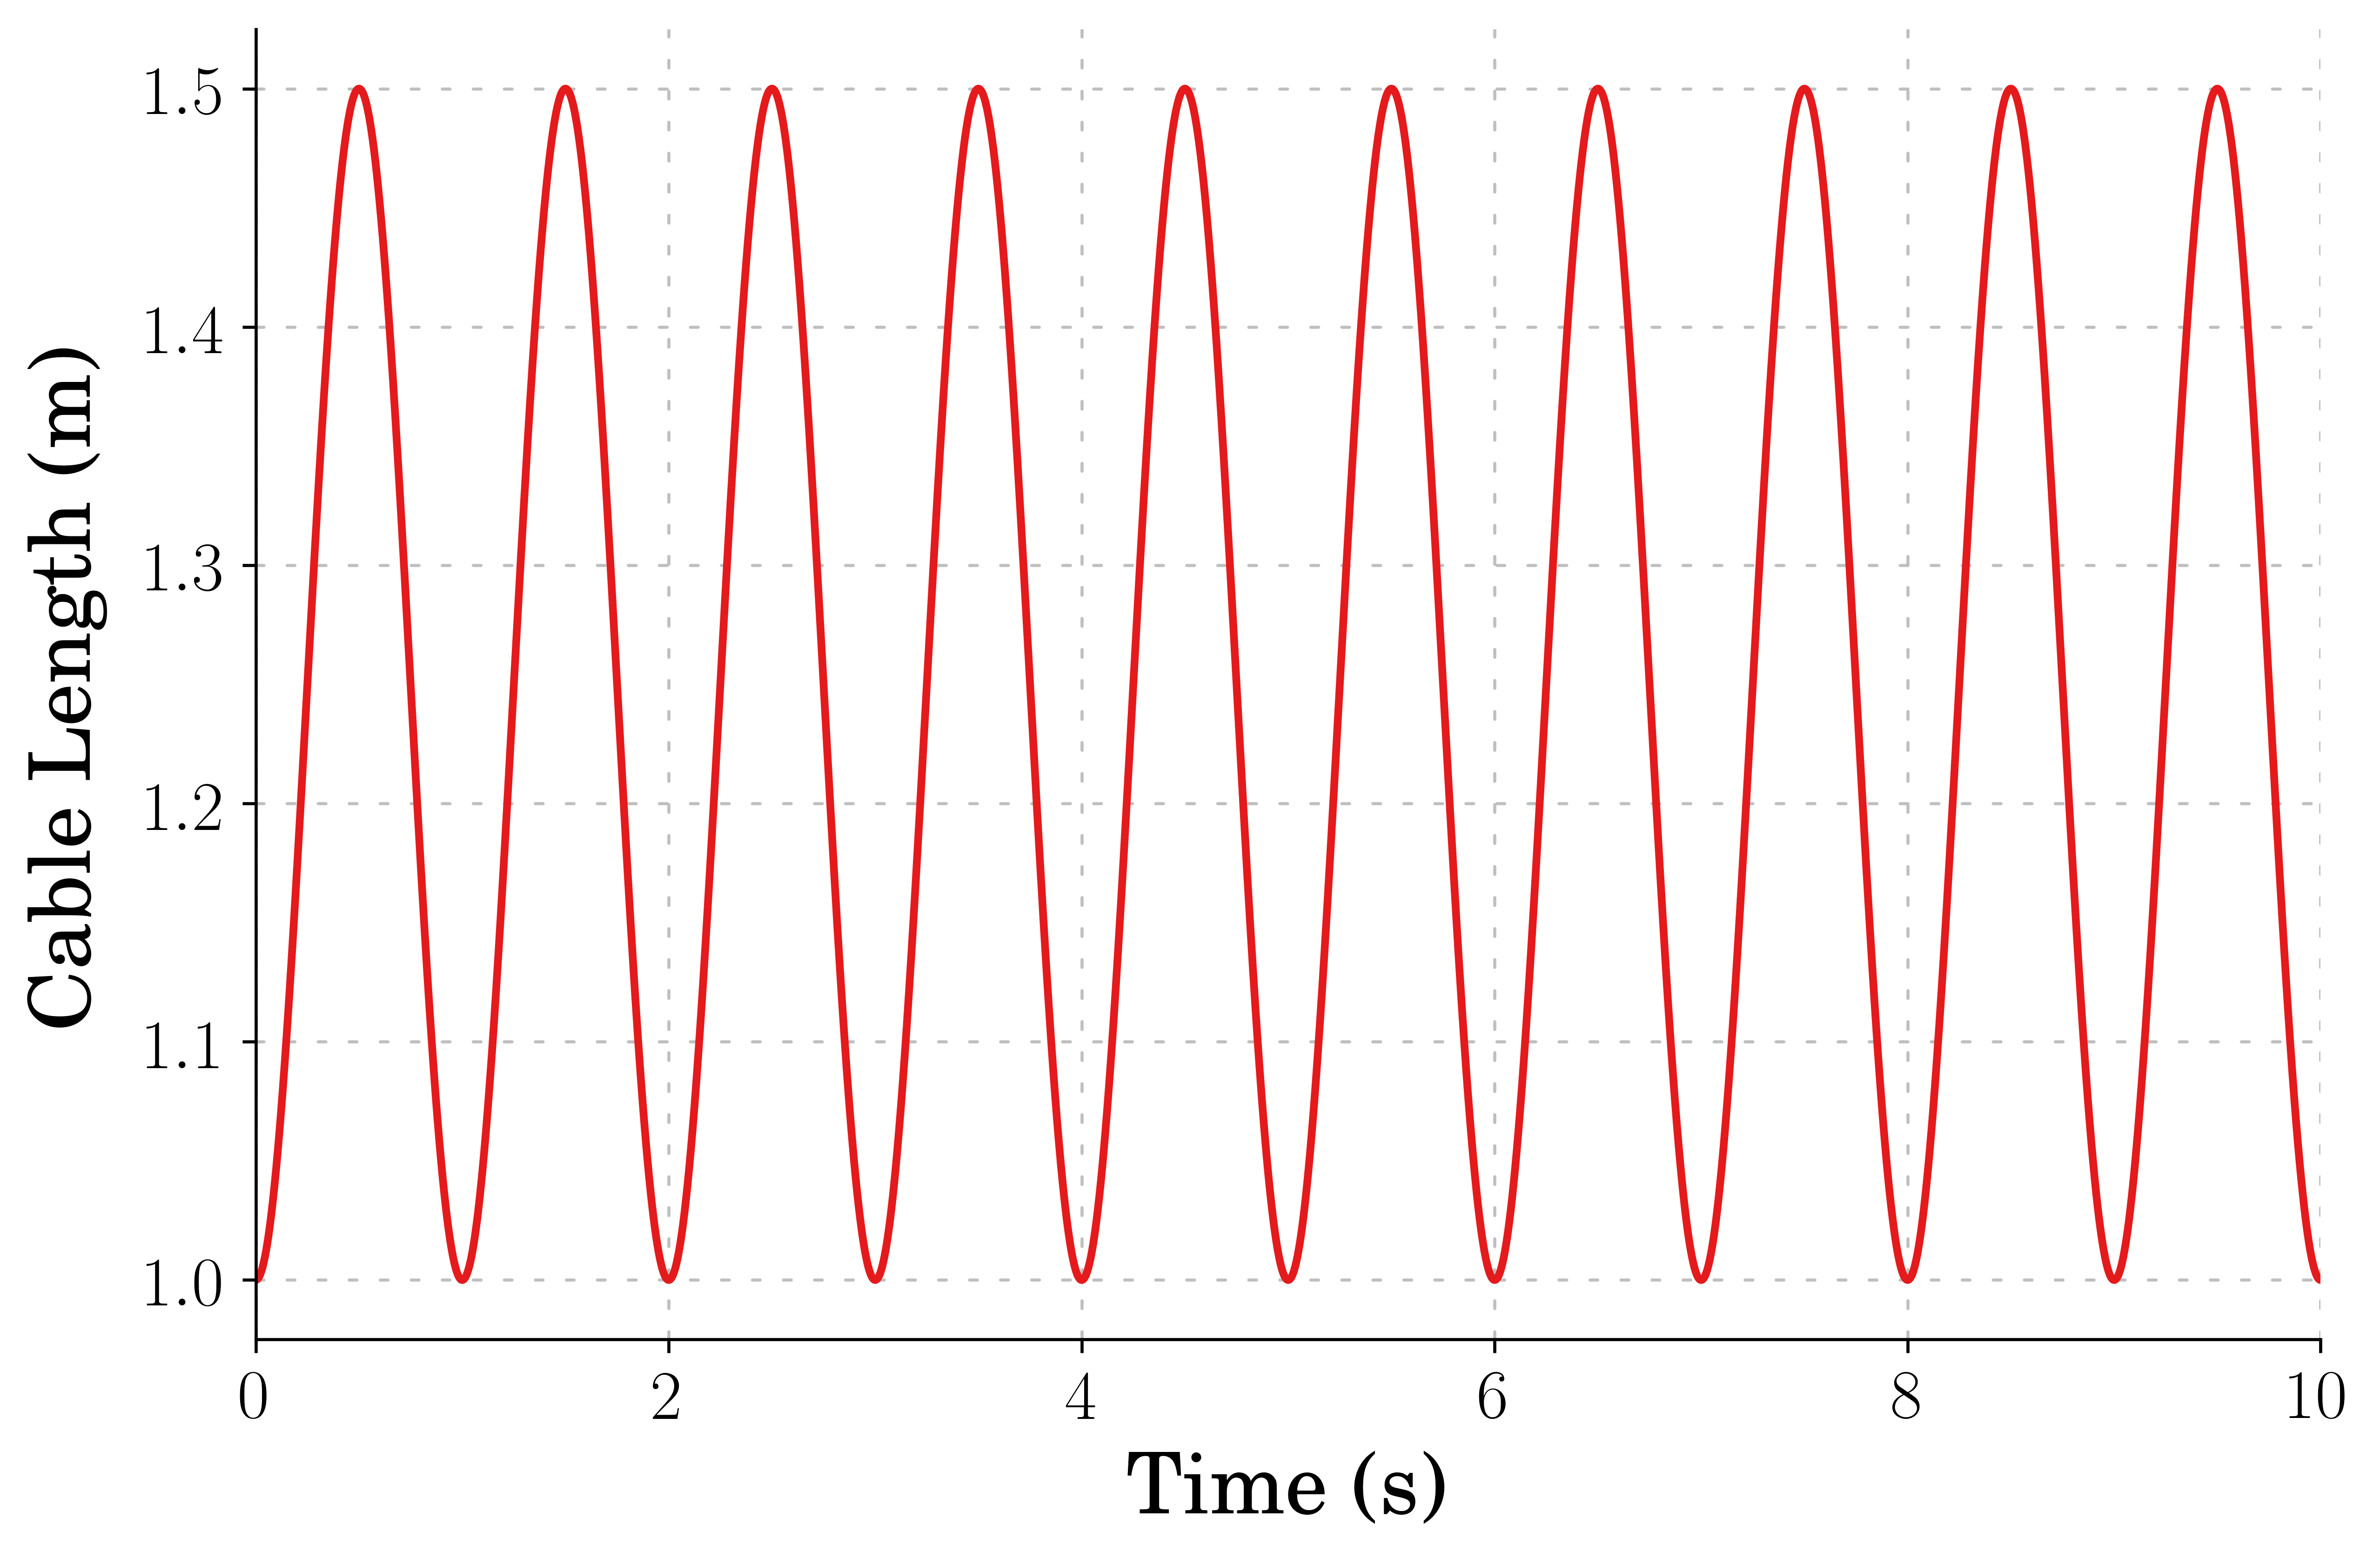

In [9]:
# Make the figure pretty, then plot the results
#   "pretty" parameters selected based on pdf output, not screen output
#   Many of these setting could also be made default by the .matplotlibrc file

# Set the plot size - 3x2 aspect ratio is best
fig = plt.figure(figsize=(6, 4))
ax = plt.gca()
plt.subplots_adjust(bottom=0.17, left=0.17, top=0.96, right=0.96)

# Change the axis units to serif
plt.setp(ax.get_ymajorticklabels(),family='serif',fontsize=18)
plt.setp(ax.get_xmajorticklabels(),family='serif',fontsize=18)

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Turn on the plot grid and set appropriate linestyle and color
ax.grid(True,linestyle=':',color='0.75')
ax.set_axisbelow(True)

# Define the X and Y axis labels
plt.xlabel('Time (s)', family='serif', fontsize=22, weight='bold', labelpad=5)
plt.ylabel('Cable Length (m)', family='serif', fontsize=22, weight='bold', labelpad=10)

# Plot the first element of resp for all time. It corresponds to the position.
plt.plot(t, resp[:,2], linewidth=2, linestyle = '-', label=r'Cable Length')

# uncomment below and set limits if needed
plt.xlim(0, stoptime)
# plt.ylim(-20,25)

# # # Create the legend, then fix the fontsize
# leg = plt.legend(loc='upper right', ncol = 2, fancybox=True)
# ltext  = leg.get_texts()
# plt.setp(ltext,family='serif',fontsize=18)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad = 0.5)

# save the figure as a high-res pdf in the current folder
# It's saved at the original 6x4 size
# plt.savefig('VariablePendulum_CableLength.pdf')

fig.set_size_inches(9, 6) # Resize the figure for better display in the notebook

<hr class = "style-end">


#### Licenses
Code is licensed under a 3-clause BSD style license. See the licenses/LICENSE.md file.

Other content is provided under a [Creative Commons Attribution-NonCommercial 4.0 International License](http://creativecommons.org/licenses/by-nc/4.0/), CC-BY-NC 4.0.

In [10]:
# Ignore this cell - We just update the CSS to make the notebook look a little bit better and easier to read

# Improve the notebook styling -- Run this first
import codecs
from IPython.core.display import HTML
try:
    css_file = 'styling/CRAWLAB_IPythonNotebook.css'
    HTML(codecs.open(css_file, 'r', 'utf-8').read())
except:
    pass # If we can't find the file, do nothing